# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

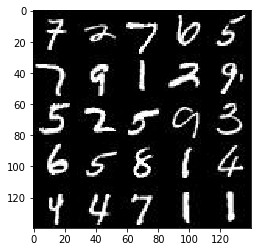

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot


mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

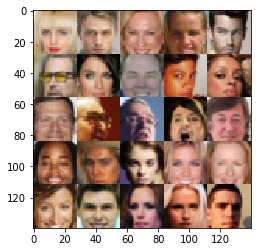

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32,(None, image_width, image_height, image_channels),name='real_input')
    z_input = tf.placeholder(tf.float32,(None, z_dim),name='z_input')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')

    
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/rajesh/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/rajesh/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/rajesh/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/rajesh/anaconda3/envs/tensorflow/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/rajesh/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().s

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    #params
    alpha = 0.2
    dropout = 0.55
    
    # TODO: Implement Function

    with tf.variable_scope('discriminator',reuse=reuse):
        conv0 = tf.layers.conv2d(images,64, 4, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        conv0 = tf.maximum(alpha * conv0, conv0)
        
        conv1 = tf.layers.conv2d(conv0, 128, 4, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        conv1 = tf.layers.batch_normalization(conv1, training=True)
        conv1 = tf.layers.dropout(conv1, dropout)
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d(conv1, 256, 4, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.layers.dropout(conv2, dropout)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
#         conv3 = tf.layers.conv2d(conv2, 512, 4, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
#         conv3 = tf.layers.batch_normalization(conv3, training=True)
#         conv3 = tf.layers.dropout(conv3, dropout)
#         conv3 = tf.maximum(alpha * conv3, conv3)
        
        flat = tf.reshape(conv2, (-1, 2*2*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    dropout = 0.45
    
    
    with tf.variable_scope("generator", reuse=not is_train):
        x = tf.layers.dense(z, 7*7*512)
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.layers.dropout(x, dropout)
        x = tf.maximum(alpha * x, x)

        
        conv1 = tf.layers.conv2d_transpose(x, 256, 4, strides=2, padding="same")
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.layers.dropout(conv1, dropout)
        conv1 = tf.maximum(alpha * conv1, conv1)

        
        conv2 = tf.layers.conv2d_transpose(conv1, 128, 4, strides=2, padding="same")
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.layers.dropout(conv2,dropout)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
#         conv3 = tf.layers.conv2d_transpose(conv2, 128, 5, strides=2, padding="same")
#         conv3 = tf.layers.batch_normalization(conv3, training=is_train)
#         conv3 = tf.layers.dropout(conv3,dropout)
#         conv3 = tf.maximum(alpha * conv3, conv3)

        
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 4, strides=1, padding="same")
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    gen_model = generator(input_z,out_channel_dim,is_train=True)
    
    d_model_real,d_logits_real =discriminator(input_real,reuse=False)
    d_model_fake,d_logits_fake =discriminator(gen_model,reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(generator(input_z, out_channel_dim, False),feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    losses = []
    
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    steps = 0
    
    #Show every...

 
    show_every = 150
    print_every = 20
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train
                steps += 1
                # Sample random noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    losses.append((train_loss_d, train_loss_g))

                    print("Epoch {}/{}...".format(i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
    np_losses = np.array(losses)
    pyplot.plot(np_losses.T[0], label='Discriminator', alpha=0.5)
    pyplot.plot(np_losses.T[1], label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()
    pyplot.show()
    print("Done!")
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.00025
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 1.0393... Generator Loss: 2.4032
Epoch 0/1... Discriminator Loss: 1.1357... Generator Loss: 1.4304
Epoch 0/1... Discriminator Loss: 0.9826... Generator Loss: 1.4118
Epoch 0/1... Discriminator Loss: 1.2084... Generator Loss: 0.6528
Epoch 0/1... Discriminator Loss: 1.4871... Generator Loss: 0.4940
Epoch 0/1... Discriminator Loss: 1.4366... Generator Loss: 0.5601
Epoch 0/1... Discriminator Loss: 1.6393... Generator Loss: 0.4030


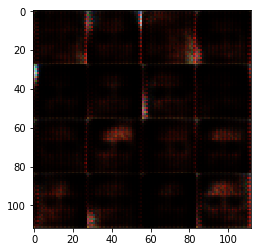

Epoch 0/1... Discriminator Loss: 1.2787... Generator Loss: 0.6329
Epoch 0/1... Discriminator Loss: 1.3147... Generator Loss: 0.5376
Epoch 0/1... Discriminator Loss: 1.1222... Generator Loss: 0.7251
Epoch 0/1... Discriminator Loss: 0.9949... Generator Loss: 0.8607
Epoch 0/1... Discriminator Loss: 1.2415... Generator Loss: 1.0844
Epoch 0/1... Discriminator Loss: 1.6625... Generator Loss: 0.3902
Epoch 0/1... Discriminator Loss: 1.3019... Generator Loss: 1.3529


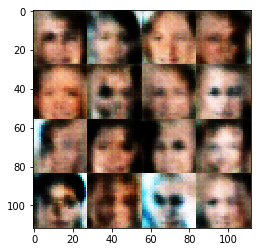

Epoch 0/1... Discriminator Loss: 1.2259... Generator Loss: 0.6892
Epoch 0/1... Discriminator Loss: 1.6832... Generator Loss: 0.3969
Epoch 0/1... Discriminator Loss: 2.0682... Generator Loss: 0.2157
Epoch 0/1... Discriminator Loss: 1.3289... Generator Loss: 0.6089
Epoch 0/1... Discriminator Loss: 1.3102... Generator Loss: 0.5942
Epoch 0/1... Discriminator Loss: 1.2600... Generator Loss: 1.0495
Epoch 0/1... Discriminator Loss: 0.9630... Generator Loss: 1.1006
Epoch 0/1... Discriminator Loss: 1.3988... Generator Loss: 0.5183


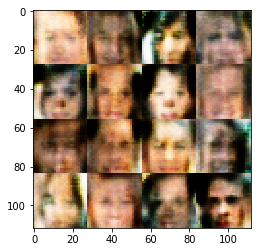

Epoch 0/1... Discriminator Loss: 1.1310... Generator Loss: 1.1800
Epoch 0/1... Discriminator Loss: 1.1663... Generator Loss: 0.8460
Epoch 0/1... Discriminator Loss: 0.8824... Generator Loss: 2.0188
Epoch 0/1... Discriminator Loss: 0.8956... Generator Loss: 1.6175
Epoch 0/1... Discriminator Loss: 1.2061... Generator Loss: 1.1767
Epoch 0/1... Discriminator Loss: 0.9612... Generator Loss: 0.9068
Epoch 0/1... Discriminator Loss: 0.6861... Generator Loss: 1.6004


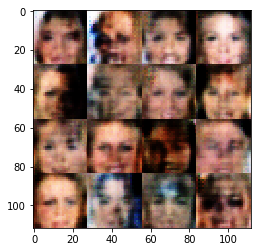

Epoch 0/1... Discriminator Loss: 1.1328... Generator Loss: 0.7539
Epoch 0/1... Discriminator Loss: 1.3801... Generator Loss: 0.6981
Epoch 0/1... Discriminator Loss: 1.9050... Generator Loss: 0.2634
Epoch 0/1... Discriminator Loss: 1.1512... Generator Loss: 0.6985
Epoch 0/1... Discriminator Loss: 1.1051... Generator Loss: 0.7816
Epoch 0/1... Discriminator Loss: 0.8408... Generator Loss: 1.0200
Epoch 0/1... Discriminator Loss: 0.9013... Generator Loss: 0.9338
Epoch 0/1... Discriminator Loss: 1.2768... Generator Loss: 2.8139


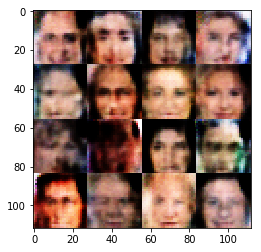

Epoch 0/1... Discriminator Loss: 0.9430... Generator Loss: 1.6749
Epoch 0/1... Discriminator Loss: 0.8170... Generator Loss: 1.2960
Epoch 0/1... Discriminator Loss: 0.9227... Generator Loss: 1.3739
Epoch 0/1... Discriminator Loss: 1.0802... Generator Loss: 1.0492
Epoch 0/1... Discriminator Loss: 0.9703... Generator Loss: 0.8701
Epoch 0/1... Discriminator Loss: 0.9427... Generator Loss: 1.2414
Epoch 0/1... Discriminator Loss: 0.8737... Generator Loss: 1.0617


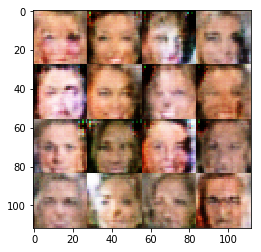

Epoch 0/1... Discriminator Loss: 1.2160... Generator Loss: 0.8314
Epoch 0/1... Discriminator Loss: 1.0331... Generator Loss: 0.8210
Epoch 0/1... Discriminator Loss: 1.1489... Generator Loss: 0.7657
Epoch 0/1... Discriminator Loss: 0.8489... Generator Loss: 1.9973
Epoch 0/1... Discriminator Loss: 1.2917... Generator Loss: 0.6171
Epoch 0/1... Discriminator Loss: 1.3547... Generator Loss: 1.7507
Epoch 0/1... Discriminator Loss: 1.2062... Generator Loss: 1.0316
Epoch 0/1... Discriminator Loss: 0.6023... Generator Loss: 2.1638


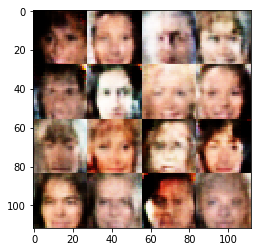

Epoch 0/1... Discriminator Loss: 1.0406... Generator Loss: 1.4901
Epoch 0/1... Discriminator Loss: 0.9469... Generator Loss: 0.9736
Epoch 0/1... Discriminator Loss: 1.0571... Generator Loss: 0.7157
Epoch 0/1... Discriminator Loss: 1.2546... Generator Loss: 0.5596
Epoch 0/1... Discriminator Loss: 1.0699... Generator Loss: 0.7551
Epoch 0/1... Discriminator Loss: 1.1670... Generator Loss: 1.2941
Epoch 0/1... Discriminator Loss: 1.4236... Generator Loss: 0.6920


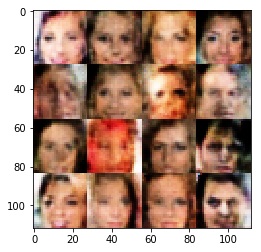

Epoch 0/1... Discriminator Loss: 1.2306... Generator Loss: 0.6985
Epoch 0/1... Discriminator Loss: 0.7597... Generator Loss: 1.8219
Epoch 0/1... Discriminator Loss: 2.0900... Generator Loss: 0.2113
Epoch 0/1... Discriminator Loss: 1.0780... Generator Loss: 2.7280
Epoch 0/1... Discriminator Loss: 0.7575... Generator Loss: 1.7605
Epoch 0/1... Discriminator Loss: 0.8250... Generator Loss: 1.0812
Epoch 0/1... Discriminator Loss: 0.9337... Generator Loss: 1.1144
Epoch 0/1... Discriminator Loss: 0.9308... Generator Loss: 1.0412


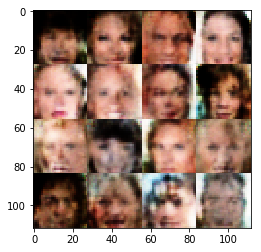

Epoch 0/1... Discriminator Loss: 1.6272... Generator Loss: 1.2504
Epoch 0/1... Discriminator Loss: 0.6153... Generator Loss: 1.9562
Epoch 0/1... Discriminator Loss: 1.2812... Generator Loss: 2.1681
Epoch 0/1... Discriminator Loss: 0.9481... Generator Loss: 0.9776
Epoch 0/1... Discriminator Loss: 1.0227... Generator Loss: 0.7863
Epoch 0/1... Discriminator Loss: 1.0553... Generator Loss: 1.4201
Epoch 0/1... Discriminator Loss: 1.0501... Generator Loss: 0.7985


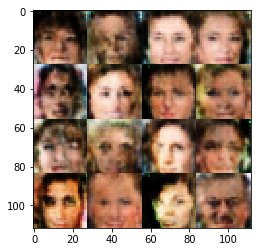

Epoch 0/1... Discriminator Loss: 0.9374... Generator Loss: 0.9536
Epoch 0/1... Discriminator Loss: 0.8332... Generator Loss: 1.0260
Epoch 0/1... Discriminator Loss: 0.6737... Generator Loss: 2.3166
Epoch 0/1... Discriminator Loss: 1.3903... Generator Loss: 0.5558
Epoch 0/1... Discriminator Loss: 0.6269... Generator Loss: 2.1273
Epoch 0/1... Discriminator Loss: 0.5362... Generator Loss: 2.2583
Epoch 0/1... Discriminator Loss: 0.7329... Generator Loss: 1.2171
Epoch 0/1... Discriminator Loss: 0.7507... Generator Loss: 1.6809


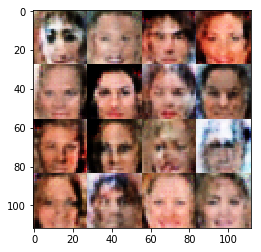

Epoch 0/1... Discriminator Loss: 0.7450... Generator Loss: 2.8135
Epoch 0/1... Discriminator Loss: 1.9124... Generator Loss: 2.4175
Epoch 0/1... Discriminator Loss: 0.7483... Generator Loss: 1.3542
Epoch 0/1... Discriminator Loss: 1.3673... Generator Loss: 0.8303
Epoch 0/1... Discriminator Loss: 0.6371... Generator Loss: 1.6376
Epoch 0/1... Discriminator Loss: 1.1478... Generator Loss: 1.1886
Epoch 0/1... Discriminator Loss: 1.9613... Generator Loss: 0.2446


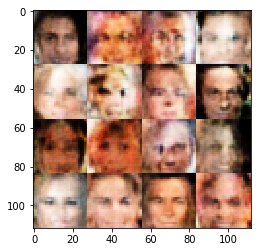

Epoch 0/1... Discriminator Loss: 1.3092... Generator Loss: 2.0237
Epoch 0/1... Discriminator Loss: 1.4269... Generator Loss: 1.2468
Epoch 0/1... Discriminator Loss: 1.2648... Generator Loss: 2.0002
Epoch 0/1... Discriminator Loss: 1.1489... Generator Loss: 0.7357
Epoch 0/1... Discriminator Loss: 0.5736... Generator Loss: 1.8202
Epoch 0/1... Discriminator Loss: 1.5454... Generator Loss: 1.6550
Epoch 0/1... Discriminator Loss: 0.8565... Generator Loss: 1.6828
Epoch 0/1... Discriminator Loss: 0.8143... Generator Loss: 1.2476


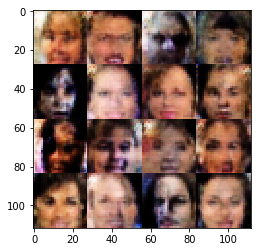

Epoch 0/1... Discriminator Loss: 1.4514... Generator Loss: 0.5134
Epoch 0/1... Discriminator Loss: 0.9069... Generator Loss: 1.3577
Epoch 0/1... Discriminator Loss: 0.8566... Generator Loss: 1.2403
Epoch 0/1... Discriminator Loss: 1.0839... Generator Loss: 0.6890
Epoch 0/1... Discriminator Loss: 1.3012... Generator Loss: 0.8649
Epoch 0/1... Discriminator Loss: 0.6565... Generator Loss: 1.7672
Epoch 0/1... Discriminator Loss: 1.3425... Generator Loss: 0.5027


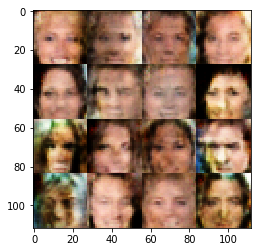

Epoch 0/1... Discriminator Loss: 0.9905... Generator Loss: 1.9887
Epoch 0/1... Discriminator Loss: 1.3871... Generator Loss: 0.4881
Epoch 0/1... Discriminator Loss: 0.7360... Generator Loss: 1.8263
Epoch 0/1... Discriminator Loss: 1.1477... Generator Loss: 0.9216
Epoch 0/1... Discriminator Loss: 0.9089... Generator Loss: 0.9053
Epoch 0/1... Discriminator Loss: 0.5839... Generator Loss: 2.1349
Epoch 0/1... Discriminator Loss: 0.7255... Generator Loss: 1.7038
Epoch 0/1... Discriminator Loss: 0.6980... Generator Loss: 2.0166


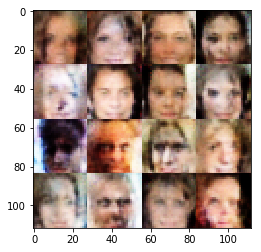

Epoch 0/1... Discriminator Loss: 0.9758... Generator Loss: 1.1450
Epoch 0/1... Discriminator Loss: 1.1244... Generator Loss: 0.7459
Epoch 0/1... Discriminator Loss: 1.3606... Generator Loss: 0.5534
Epoch 0/1... Discriminator Loss: 1.2047... Generator Loss: 1.9152
Epoch 0/1... Discriminator Loss: 1.0729... Generator Loss: 1.3351
Epoch 0/1... Discriminator Loss: 1.3533... Generator Loss: 0.5487
Epoch 0/1... Discriminator Loss: 1.5101... Generator Loss: 0.5772


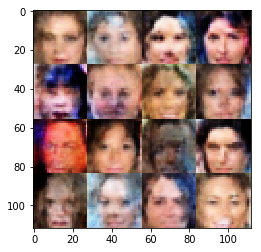

Epoch 0/1... Discriminator Loss: 0.8169... Generator Loss: 1.0670
Epoch 0/1... Discriminator Loss: 2.2237... Generator Loss: 0.1777
Epoch 0/1... Discriminator Loss: 0.9824... Generator Loss: 0.8619
Epoch 0/1... Discriminator Loss: 1.1909... Generator Loss: 1.3091
Epoch 0/1... Discriminator Loss: 0.9481... Generator Loss: 1.0039
Epoch 0/1... Discriminator Loss: 0.9374... Generator Loss: 0.9504
Epoch 0/1... Discriminator Loss: 1.2201... Generator Loss: 0.8565
Epoch 0/1... Discriminator Loss: 0.8607... Generator Loss: 1.2136


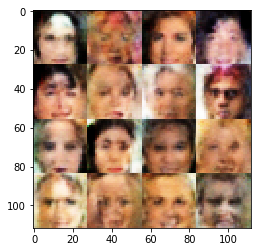

Epoch 0/1... Discriminator Loss: 0.8249... Generator Loss: 1.2536
Epoch 0/1... Discriminator Loss: 1.5380... Generator Loss: 1.8765
Epoch 0/1... Discriminator Loss: 1.4968... Generator Loss: 0.4068
Epoch 0/1... Discriminator Loss: 1.0931... Generator Loss: 1.0168
Epoch 0/1... Discriminator Loss: 1.4047... Generator Loss: 0.5506
Epoch 0/1... Discriminator Loss: 1.2595... Generator Loss: 0.7186
Epoch 0/1... Discriminator Loss: 1.0127... Generator Loss: 1.0790


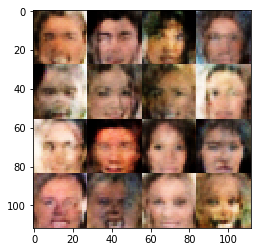

Epoch 0/1... Discriminator Loss: 1.4888... Generator Loss: 0.4140
Epoch 0/1... Discriminator Loss: 1.2570... Generator Loss: 0.6113
Epoch 0/1... Discriminator Loss: 1.3685... Generator Loss: 0.5072
Epoch 0/1... Discriminator Loss: 0.8909... Generator Loss: 0.9445
Epoch 0/1... Discriminator Loss: 1.7281... Generator Loss: 0.3026
Epoch 0/1... Discriminator Loss: 0.8416... Generator Loss: 1.0788
Epoch 0/1... Discriminator Loss: 1.0469... Generator Loss: 0.7455
Epoch 0/1... Discriminator Loss: 1.0781... Generator Loss: 1.5176


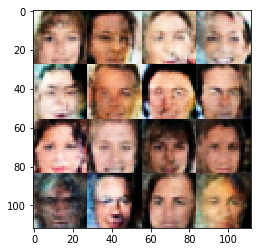

Epoch 0/1... Discriminator Loss: 0.7743... Generator Loss: 1.1792
Epoch 0/1... Discriminator Loss: 1.5221... Generator Loss: 0.4842
Epoch 0/1... Discriminator Loss: 1.0994... Generator Loss: 0.8337
Epoch 0/1... Discriminator Loss: 1.4924... Generator Loss: 1.2074
Epoch 0/1... Discriminator Loss: 1.2877... Generator Loss: 1.8937
Epoch 0/1... Discriminator Loss: 1.3723... Generator Loss: 0.7551
Epoch 0/1... Discriminator Loss: 0.6366... Generator Loss: 1.7560


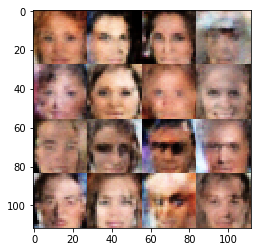

Epoch 0/1... Discriminator Loss: 0.9432... Generator Loss: 1.1526
Epoch 0/1... Discriminator Loss: 1.1038... Generator Loss: 1.2389
Epoch 0/1... Discriminator Loss: 1.0753... Generator Loss: 0.7820
Epoch 0/1... Discriminator Loss: 1.4443... Generator Loss: 0.4866
Epoch 0/1... Discriminator Loss: 1.6384... Generator Loss: 1.4430
Epoch 0/1... Discriminator Loss: 0.9196... Generator Loss: 0.9105
Epoch 0/1... Discriminator Loss: 0.8359... Generator Loss: 1.3647
Epoch 0/1... Discriminator Loss: 0.9003... Generator Loss: 1.7172


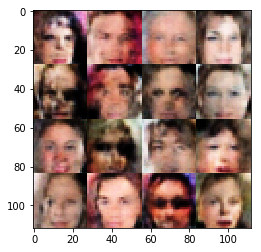

Epoch 0/1... Discriminator Loss: 1.1268... Generator Loss: 0.7896
Epoch 0/1... Discriminator Loss: 0.8041... Generator Loss: 1.1900
Epoch 0/1... Discriminator Loss: 1.2317... Generator Loss: 0.7248
Epoch 0/1... Discriminator Loss: 0.9931... Generator Loss: 1.3126
Epoch 0/1... Discriminator Loss: 0.9246... Generator Loss: 1.0530
Epoch 0/1... Discriminator Loss: 1.2540... Generator Loss: 1.2242
Epoch 0/1... Discriminator Loss: 1.1985... Generator Loss: 0.7178


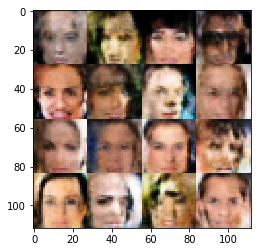

Epoch 0/1... Discriminator Loss: 1.2513... Generator Loss: 0.9995
Epoch 0/1... Discriminator Loss: 1.2936... Generator Loss: 0.8461
Epoch 0/1... Discriminator Loss: 0.9093... Generator Loss: 0.9861
Epoch 0/1... Discriminator Loss: 1.5597... Generator Loss: 1.3336
Epoch 0/1... Discriminator Loss: 1.1176... Generator Loss: 0.8102
Epoch 0/1... Discriminator Loss: 1.1119... Generator Loss: 0.8742
Epoch 0/1... Discriminator Loss: 1.0694... Generator Loss: 0.7281
Epoch 0/1... Discriminator Loss: 0.7812... Generator Loss: 1.2325


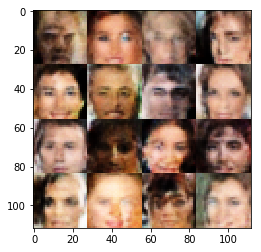

Epoch 0/1... Discriminator Loss: 1.3858... Generator Loss: 0.5072
Epoch 0/1... Discriminator Loss: 1.2177... Generator Loss: 1.0241
Epoch 0/1... Discriminator Loss: 1.3384... Generator Loss: 1.0002
Epoch 0/1... Discriminator Loss: 0.7003... Generator Loss: 1.3113
Epoch 0/1... Discriminator Loss: 1.2443... Generator Loss: 1.3071
Epoch 0/1... Discriminator Loss: 1.2677... Generator Loss: 0.7990
Epoch 0/1... Discriminator Loss: 1.5749... Generator Loss: 0.3730


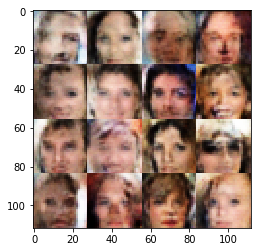

Epoch 0/1... Discriminator Loss: 1.4537... Generator Loss: 0.5042
Epoch 0/1... Discriminator Loss: 1.1072... Generator Loss: 0.9292
Epoch 0/1... Discriminator Loss: 1.0232... Generator Loss: 1.0898
Epoch 0/1... Discriminator Loss: 1.0995... Generator Loss: 0.7937
Epoch 0/1... Discriminator Loss: 0.9233... Generator Loss: 1.1552
Epoch 0/1... Discriminator Loss: 1.3317... Generator Loss: 0.5395
Epoch 0/1... Discriminator Loss: 1.3036... Generator Loss: 0.6271
Epoch 0/1... Discriminator Loss: 1.4004... Generator Loss: 0.5589


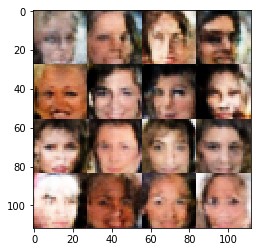

Epoch 0/1... Discriminator Loss: 1.1463... Generator Loss: 1.4159
Epoch 0/1... Discriminator Loss: 1.2983... Generator Loss: 1.0304
Epoch 0/1... Discriminator Loss: 1.4415... Generator Loss: 0.5427
Epoch 0/1... Discriminator Loss: 1.1399... Generator Loss: 0.8152
Epoch 0/1... Discriminator Loss: 1.6476... Generator Loss: 0.3701
Epoch 0/1... Discriminator Loss: 1.2304... Generator Loss: 0.9561
Epoch 0/1... Discriminator Loss: 1.1466... Generator Loss: 1.0473


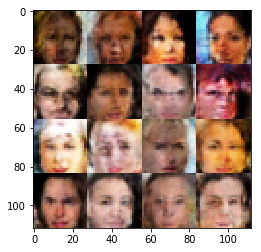

Epoch 0/1... Discriminator Loss: 1.1404... Generator Loss: 0.8326
Epoch 0/1... Discriminator Loss: 0.9068... Generator Loss: 1.0498
Epoch 0/1... Discriminator Loss: 0.9553... Generator Loss: 0.9197
Epoch 0/1... Discriminator Loss: 1.2376... Generator Loss: 0.6276
Epoch 0/1... Discriminator Loss: 1.0901... Generator Loss: 0.7701
Epoch 0/1... Discriminator Loss: 0.8502... Generator Loss: 1.1625
Epoch 0/1... Discriminator Loss: 1.2534... Generator Loss: 0.8619
Epoch 0/1... Discriminator Loss: 1.5237... Generator Loss: 0.4738


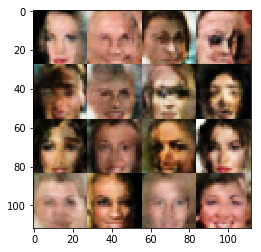

Epoch 0/1... Discriminator Loss: 1.2510... Generator Loss: 0.7350
Epoch 0/1... Discriminator Loss: 1.1893... Generator Loss: 0.6952
Epoch 0/1... Discriminator Loss: 2.3242... Generator Loss: 0.1731
Epoch 0/1... Discriminator Loss: 1.6722... Generator Loss: 0.4328
Epoch 0/1... Discriminator Loss: 1.3195... Generator Loss: 0.6159
Epoch 0/1... Discriminator Loss: 1.0413... Generator Loss: 1.6795
Epoch 0/1... Discriminator Loss: 1.4663... Generator Loss: 0.6499


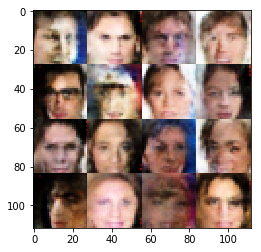

Epoch 0/1... Discriminator Loss: 0.7555... Generator Loss: 2.0216
Epoch 0/1... Discriminator Loss: 1.2702... Generator Loss: 0.8869
Epoch 0/1... Discriminator Loss: 1.2291... Generator Loss: 0.5962
Epoch 0/1... Discriminator Loss: 1.3596... Generator Loss: 0.6765
Epoch 0/1... Discriminator Loss: 0.7399... Generator Loss: 1.4995
Epoch 0/1... Discriminator Loss: 1.4268... Generator Loss: 0.9335
Epoch 0/1... Discriminator Loss: 1.2000... Generator Loss: 0.7941
Epoch 0/1... Discriminator Loss: 1.2841... Generator Loss: 1.0714


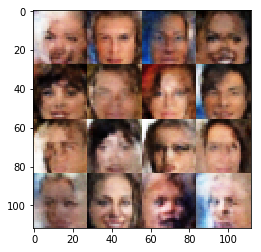

Epoch 0/1... Discriminator Loss: 1.0778... Generator Loss: 1.1971
Epoch 0/1... Discriminator Loss: 1.3225... Generator Loss: 0.6729
Epoch 0/1... Discriminator Loss: 1.3931... Generator Loss: 0.5565
Epoch 0/1... Discriminator Loss: 1.4774... Generator Loss: 1.3753
Epoch 0/1... Discriminator Loss: 0.8493... Generator Loss: 1.5442
Epoch 0/1... Discriminator Loss: 1.1723... Generator Loss: 0.8079
Epoch 0/1... Discriminator Loss: 1.2207... Generator Loss: 0.9019


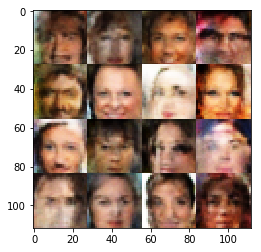

Epoch 0/1... Discriminator Loss: 1.0929... Generator Loss: 1.0889
Epoch 0/1... Discriminator Loss: 1.3243... Generator Loss: 0.8983
Epoch 0/1... Discriminator Loss: 1.3473... Generator Loss: 0.8812
Epoch 0/1... Discriminator Loss: 1.2187... Generator Loss: 0.7709
Epoch 0/1... Discriminator Loss: 1.3301... Generator Loss: 0.6702
Epoch 0/1... Discriminator Loss: 1.2555... Generator Loss: 0.6689
Epoch 0/1... Discriminator Loss: 1.1325... Generator Loss: 0.8127
Epoch 0/1... Discriminator Loss: 0.8688... Generator Loss: 2.3711


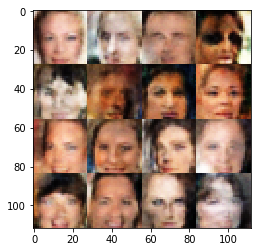

Epoch 0/1... Discriminator Loss: 1.5161... Generator Loss: 0.4184
Epoch 0/1... Discriminator Loss: 1.2708... Generator Loss: 0.8027
Epoch 0/1... Discriminator Loss: 1.0891... Generator Loss: 0.9181
Epoch 0/1... Discriminator Loss: 1.2195... Generator Loss: 0.9266
Epoch 0/1... Discriminator Loss: 1.3018... Generator Loss: 1.5569
Epoch 0/1... Discriminator Loss: 1.0879... Generator Loss: 1.0051
Epoch 0/1... Discriminator Loss: 1.4602... Generator Loss: 0.6579


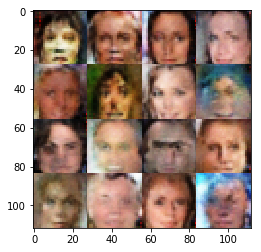

Epoch 0/1... Discriminator Loss: 0.6822... Generator Loss: 2.5575
Epoch 0/1... Discriminator Loss: 1.5050... Generator Loss: 0.9339
Epoch 0/1... Discriminator Loss: 1.0746... Generator Loss: 1.1058
Epoch 0/1... Discriminator Loss: 1.1177... Generator Loss: 0.9042
Epoch 0/1... Discriminator Loss: 1.2726... Generator Loss: 0.6262
Epoch 0/1... Discriminator Loss: 1.5692... Generator Loss: 0.7327
Epoch 0/1... Discriminator Loss: 1.0494... Generator Loss: 1.0255
Epoch 0/1... Discriminator Loss: 1.3539... Generator Loss: 0.7856


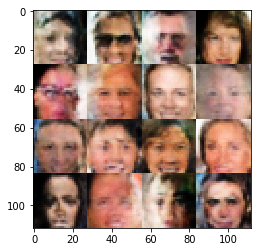

Epoch 0/1... Discriminator Loss: 1.1801... Generator Loss: 0.8273
Epoch 0/1... Discriminator Loss: 1.5002... Generator Loss: 0.4809
Epoch 0/1... Discriminator Loss: 1.4227... Generator Loss: 0.4745
Epoch 0/1... Discriminator Loss: 1.2335... Generator Loss: 0.9854
Epoch 0/1... Discriminator Loss: 1.4138... Generator Loss: 0.5651
Epoch 0/1... Discriminator Loss: 1.0386... Generator Loss: 1.1271
Epoch 0/1... Discriminator Loss: 1.2347... Generator Loss: 1.1307


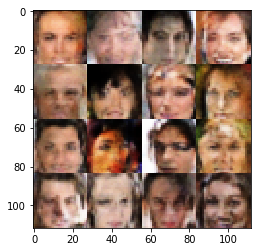

Epoch 0/1... Discriminator Loss: 1.0907... Generator Loss: 1.2222
Epoch 0/1... Discriminator Loss: 1.2637... Generator Loss: 0.7124
Epoch 0/1... Discriminator Loss: 1.5380... Generator Loss: 0.5468
Epoch 0/1... Discriminator Loss: 0.7464... Generator Loss: 1.3037
Epoch 0/1... Discriminator Loss: 0.5144... Generator Loss: 2.1298
Epoch 0/1... Discriminator Loss: 1.2253... Generator Loss: 0.5899
Epoch 0/1... Discriminator Loss: 1.1336... Generator Loss: 1.0637
Epoch 0/1... Discriminator Loss: 1.2584... Generator Loss: 0.7387


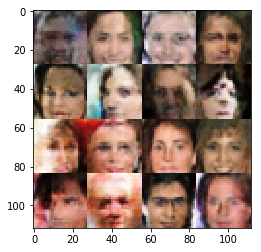

Epoch 0/1... Discriminator Loss: 1.0486... Generator Loss: 0.8152
Epoch 0/1... Discriminator Loss: 1.1499... Generator Loss: 1.0321
Epoch 0/1... Discriminator Loss: 1.1231... Generator Loss: 0.7981
Epoch 0/1... Discriminator Loss: 1.6210... Generator Loss: 0.3849
Epoch 0/1... Discriminator Loss: 1.2146... Generator Loss: 0.7621
Epoch 0/1... Discriminator Loss: 1.1240... Generator Loss: 1.2486
Epoch 0/1... Discriminator Loss: 1.1117... Generator Loss: 0.7728


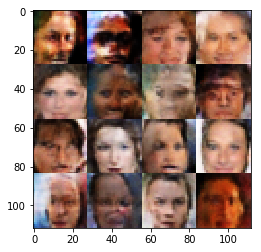

Epoch 0/1... Discriminator Loss: 1.1712... Generator Loss: 1.0965
Epoch 0/1... Discriminator Loss: 1.2670... Generator Loss: 0.5878
Epoch 0/1... Discriminator Loss: 1.1425... Generator Loss: 0.8147
Epoch 0/1... Discriminator Loss: 1.4293... Generator Loss: 0.5222
Epoch 0/1... Discriminator Loss: 1.1318... Generator Loss: 0.8399
Epoch 0/1... Discriminator Loss: 1.2995... Generator Loss: 0.6355
Epoch 0/1... Discriminator Loss: 1.3095... Generator Loss: 0.7250
Epoch 0/1... Discriminator Loss: 0.9617... Generator Loss: 1.1238


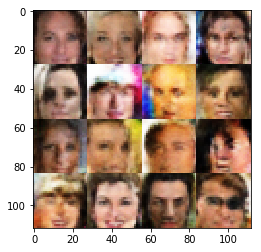

Epoch 0/1... Discriminator Loss: 1.1575... Generator Loss: 0.7890
Epoch 0/1... Discriminator Loss: 1.4666... Generator Loss: 1.0669
Epoch 0/1... Discriminator Loss: 1.8031... Generator Loss: 0.3334
Epoch 0/1... Discriminator Loss: 1.4457... Generator Loss: 0.4910
Epoch 0/1... Discriminator Loss: 1.3918... Generator Loss: 0.6029
Epoch 0/1... Discriminator Loss: 1.1341... Generator Loss: 0.8252
Epoch 0/1... Discriminator Loss: 1.3095... Generator Loss: 0.6089


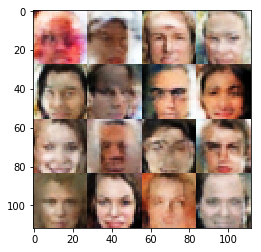

Epoch 0/1... Discriminator Loss: 1.3361... Generator Loss: 0.5265
Epoch 0/1... Discriminator Loss: 1.2859... Generator Loss: 0.7679
Epoch 0/1... Discriminator Loss: 1.2663... Generator Loss: 0.7361
Epoch 0/1... Discriminator Loss: 0.8674... Generator Loss: 1.5660
Epoch 0/1... Discriminator Loss: 1.4983... Generator Loss: 1.1195
Epoch 0/1... Discriminator Loss: 1.0897... Generator Loss: 1.2568
Epoch 0/1... Discriminator Loss: 1.1974... Generator Loss: 0.9472
Epoch 0/1... Discriminator Loss: 1.3375... Generator Loss: 0.5590


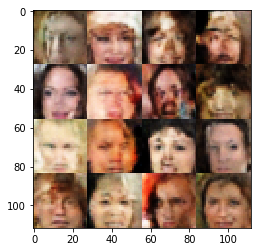

Epoch 0/1... Discriminator Loss: 1.2526... Generator Loss: 1.0142
Epoch 0/1... Discriminator Loss: 1.1310... Generator Loss: 0.9687
Epoch 0/1... Discriminator Loss: 1.2302... Generator Loss: 0.6475
Epoch 0/1... Discriminator Loss: 1.1162... Generator Loss: 0.7370
Epoch 0/1... Discriminator Loss: 1.1477... Generator Loss: 1.0224
Epoch 0/1... Discriminator Loss: 1.2448... Generator Loss: 0.6690
Epoch 0/1... Discriminator Loss: 0.8983... Generator Loss: 0.9878


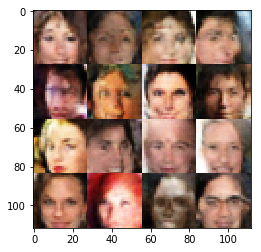

Epoch 0/1... Discriminator Loss: 1.0661... Generator Loss: 0.9050
Epoch 0/1... Discriminator Loss: 1.5135... Generator Loss: 0.5272
Epoch 0/1... Discriminator Loss: 1.4178... Generator Loss: 0.5748
Epoch 0/1... Discriminator Loss: 1.3784... Generator Loss: 0.5450
Epoch 0/1... Discriminator Loss: 1.6458... Generator Loss: 0.3575
Epoch 0/1... Discriminator Loss: 1.3278... Generator Loss: 0.6555
Epoch 0/1... Discriminator Loss: 1.1835... Generator Loss: 0.8931
Epoch 0/1... Discriminator Loss: 1.3351... Generator Loss: 0.5919


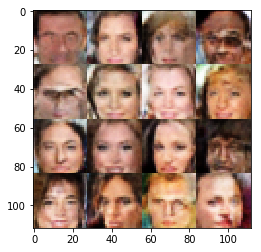

Epoch 0/1... Discriminator Loss: 1.2428... Generator Loss: 0.8894
Epoch 0/1... Discriminator Loss: 0.7159... Generator Loss: 1.8990
Epoch 0/1... Discriminator Loss: 1.0371... Generator Loss: 1.0000
Epoch 0/1... Discriminator Loss: 1.3873... Generator Loss: 0.7769
Epoch 0/1... Discriminator Loss: 1.2381... Generator Loss: 0.7583
Epoch 0/1... Discriminator Loss: 1.2486... Generator Loss: 1.0917
Epoch 0/1... Discriminator Loss: 1.4997... Generator Loss: 0.4687


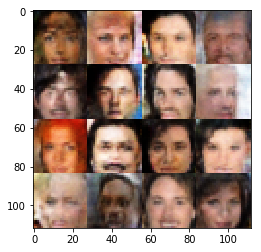

Epoch 0/1... Discriminator Loss: 1.1330... Generator Loss: 0.9697
Epoch 0/1... Discriminator Loss: 1.1537... Generator Loss: 0.9134


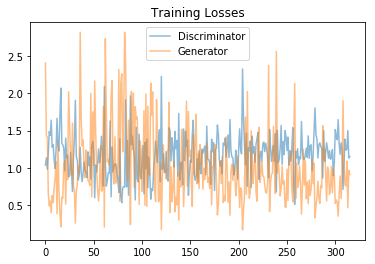

Done!


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0003
beta1 = 0.09

# learning_rate = 0.0003
# beta1 = 0.17


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.